In [70]:
import pandas as pd
import numpy as np
import re
import nltk
import random

from pathlib import Path

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score

from nltk.corpus import wordnet
from nltk import pos_tag, word_tokenize
from nltk.stem import WordNetLemmatizer

# Reproducibility seeds
np.random.seed(42)
random.seed(42)

In [71]:
## download required NLTK data files to a specific directory
# TODO: make a separate script that does this only once


NLTK_DIR = Path("../data/nltk_data")
NLTK_DIR.mkdir(parents=True, exist_ok=True)
nltk.data.path.append(str(NLTK_DIR))

resources = [
    "punkt",
    "stopwords",
    "wordnet",
    "omw-1.4",
    "averaged_perceptron_tagger_eng",
    "averaged_perceptron_tagger",
]

for resource in resources:
    nltk.download(resource, download_dir=str(NLTK_DIR))

print(f"NLTK data downloaded to {NLTK_DIR.resolve()}")

NLTK data downloaded to /Users/alinaponomareva/Documents/UZH/ETSP/ESTP_project/data/nltk_data


[nltk_data] Downloading package punkt to ../data/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to ../data/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to ../data/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to ../data/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     ../data/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     ../data/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [72]:
## preprocessing function for NLTK tokenizer + lemmatizer

from nltk.corpus import stopwords
STOP_WORDS = set(stopwords.words('english'))

def get_wordnet_pos(tag):
    """Map POS tag to first character lemmatize() accepts"""
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN


def nltk_preprocess(text):
    # make sure we get useful tokens
    token_pattern = re.compile(r"(?u)\b[^\W\d_]{2,}\b")  # yoinked from TfidfVectorizer
    txt = "" if not isinstance(text, str) else text.lower()
    words = token_pattern.findall(txt)
    pos_tags = pos_tag(words)
    lemmatizer = WordNetLemmatizer()
    lemmatized_words = [lemmatizer.lemmatize(word, get_wordnet_pos(tag)) for word, tag in pos_tags]
    # remove stopwords after lemmatization
    lemmatized_words = [w for w in lemmatized_words if w not in STOP_WORDS]
    return lemmatized_words

In [73]:
## get data and prepare train split and dev split

# get the combined dataset
df = pd.read_csv("../data/processed/text_combined.csv", index_col=0)

# get only train part of the dataset
df_train = df[df["split"] == "train"].reset_index(drop=True)

# get only dev part of the dataset
df_dev = df[df["split"] == "dev"].reset_index(drop=True)

# get the necessary columns out of df_train
X = df_train["text"]
y_depr = df_train["target_depr"]

print(df_train.shape)
display(df_train.head())
print(X.index.equals(y_depr.index))

# get the necessary columns out of df_dev
X_val = df_dev["text"]
y_depr_val = df_dev["target_depr"]

print(df_dev.shape)
display(df_dev.head())
print(X_val.index.equals(y_depr_val.index))

(163, 5)


,participant_id,text,target_depr,target_ptsd,split
0,302,just move around a little bit when you're fini...,0,0,train
1,303,wow okay when you're finished when she's done ...,0,0,train
2,304,so we'll just move around a little bit tonight...,0,0,train
3,305,okay looks good so we can just move around a l...,0,0,train
4,307,looking at you all right okay so now let's mak...,0,0,train


True
(56, 5)


,participant_id,text,target_depr,target_ptsd,split
0,300,so I'm going to interview in Spanish okay good...,0,0,dev
1,301,yeah there's also on Craigslist so that's why ...,0,0,dev
2,306,okay looks like we're good. Let's move around ...,0,0,dev
3,317,equipment okay how was okay thanks are you oka...,0,1,dev
4,320,perfect okay and okay and then I will let you ...,0,1,dev


True


In [84]:
y_depr.value_counts(normalize=True)

target_depr
0    0.773006
1    0.226994
Name: proportion, dtype: float64

In [85]:
# create pipeline

from sklearn.model_selection import StratifiedKFold

pipeline = Pipeline ([
    ('vectorizer',TfidfVectorizer(
        tokenizer=nltk_preprocess, #TODO: try different tokenizers in gridsearch
        preprocessor=None,
        lowercase=False,
        token_pattern=None,
        ngram_range=(1,2),
        min_df=2,
        max_df=0.9
    )),
    ('classifier',LogisticRegression(max_iter=2000, class_weight='balanced', solver='liblinear', random_state=42))
])

# Define a reproducible CV splitter
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [86]:
# train 

from joblib import parallel_backend

# Use threads to avoid pickling issues with custom tokenizer
with parallel_backend("threading", n_jobs=-1):
    scores = cross_val_score(pipeline, X, y_depr, cv=cv, n_jobs=-1, verbose=1)
print('Cross-validation scores', scores)
print('Average cross-validation score', scores.mean())

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 11 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   23.3s remaining:   35.0s


Cross-validation scores [0.78787879 0.75757576 0.78787879 0.78125    0.78125   ]
Average cross-validation score 0.7791666666666666


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   23.7s finished


In [87]:
# fit on full train
pipeline.fit(X, y_depr)

,steps,"[('vectorizer', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,input,'content'
,encoding,'utf-8'
,decode_error,'strict'
,strip_accents,None
,lowercase,False
,preprocessor,None
,tokenizer,<function nlt...t 0x1337ed300>


Classification report on dev set:
              precision    recall  f1-score    support
0              0.800000  1.000000  0.888889  44.000000
1              1.000000  0.083333  0.153846  12.000000
accuracy       0.803571  0.803571  0.803571   0.803571
macro avg      0.900000  0.541667  0.521368  56.000000
weighted avg   0.842857  0.803571  0.731380  56.000000


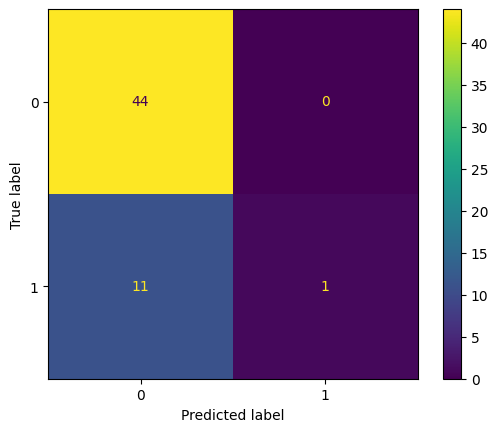

In [88]:
# evaluate on dev set
from sklearn.metrics import classification_report
y_pred = pipeline.predict(X_val)

# Detailed Report on standard metrics
report_dict = classification_report(y_depr_val, y_pred, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()
numeric_cols = ['precision', 'recall', 'f1-score']

print("Classification report on dev set:")
print(report_df)

# print confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

ConfusionMatrixDisplay.from_estimator(pipeline, X_val, y_depr_val)
plt.show()